### Imports and data load

In [2]:
## imports (use requirements.txt for dependencies)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import sklearn.metrics as metrics
import tensorflow as tf

2024-12-19 15:01:29.496558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Read and show head of input data
df_input = pd.read_csv('../resources/depression_data.csv')
df_input.head()

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


### Basic Data Checks/Cleaning
The input data is fully populated and set to reasonable data types.

The "Name" field has some duplication. In the context of the problem I have assumed this is a reflection of forename/surname pairs generated from a limited list, in a real-world situation high duplication should be checked to ensure patients are not appearing multiple times

In [4]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

In [5]:
df_input.nunique()

Name                            196851
Age                                 63
Marital Status                       4
Education Level                      5
Number of Children                   5
Smoking Status                       3
Physical Activity Level              3
Employment Status                    2
Income                          405282
Alcohol Consumption                  3
Dietary Habits                       3
Sleep Patterns                       3
History of Mental Illness            2
History of Substance Abuse           2
Family History of Depression         2
Chronic Medical Conditions           2
dtype: int64

In [6]:
df_input.duplicated().any()


False

### EDA and Feature engineering
- Name is removed as it is unlikely to be a useful predictor.
- True/False columns are converted to numerical
- Square root of income is taken to reduce right-skew
- Analysis of correlation between features

In [7]:
df_input

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413763,Sean Miller,68,Married,Master's Degree,0,Former,Moderate,Employed,109233.43,Low,Healthy,Good,No,No,No,No
413764,Christina Brown,26,Single,Bachelor's Degree,0,Current,Active,Employed,96760.97,Low,Healthy,Poor,Yes,Yes,No,Yes
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,No,No,Yes,Yes
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,No,Yes,No,No


In [ ]:
# drop 'name' as it is unlikely to be a useful feature
data = df_input.drop(['Name'], axis = 1)
# convert binary columns to numeric
data['History of Mental Illness'] = data["History of Mental Illness"].replace(('Yes', 'No'), (1, 0))
data['History of Substance Abuse'] = data["History of Substance Abuse"].replace(('Yes', 'No'), (1, 0))
data['Family History of Depression'] = data["Family History of Depression"].replace(('Yes', 'No'), (1, 0))
data['Chronic Medical Conditions'] = data["Chronic Medical Conditions"].replace(('Yes', 'No'), (1, 0))
# create children flag
data['Has Children Flag'] = data['Number of Children'].where(data['Number of Children']==0, 1)
data['Income Square Root'] = np.sqrt(data['Income'])

data.describe(include='all').T

/var/folders/gs/zrjdwm714r1fpj6csntklm3m0000gn/T/ipykernel_20786/2591249481.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['History of Mental Illness'] = data["History of Mental Illness"].replace(('Yes', 'No'), (1, 0))
/var/folders/gs/zrjdwm714r1fpj6csntklm3m0000gn/T/ipykernel_20786/2591249481.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['History of Substance Abuse'] = data["History of Substance Abuse"].replace(('Yes', 'No'), (1, 0))
/var/folders/gs/zrjdwm714r1fpj6csntklm3m0000gn/T/ipykernel_20786/2591249481.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,413768.0,NaN,NaN,NaN,49.000713,18.158759,18.0,33.0,49.0,65.0,80.0
Marital Status,413768,4,Married,240444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,413768,5,Bachelor's Degree,124329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number of Children,413768.0,NaN,NaN,NaN,1.298972,1.237054,0.0,0.0,1.0,2.0,4.0
Smoking Status,413768,3,Non-smoker,247416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Physical Activity Level,413768,3,Sedentary,176850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employment Status,413768,2,Employed,265659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,413768.0,NaN,NaN,NaN,50661.707971,40624.100565,0.41,21001.03,37520.135,76616.3,209995.22
Alcohol Consumption,413768,3,Moderate,173440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dietary Habits,413768,3,Unhealthy,170817,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cat_cols=data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()

### Review distribution and skew of numeric features

Age
Skew : 0.0


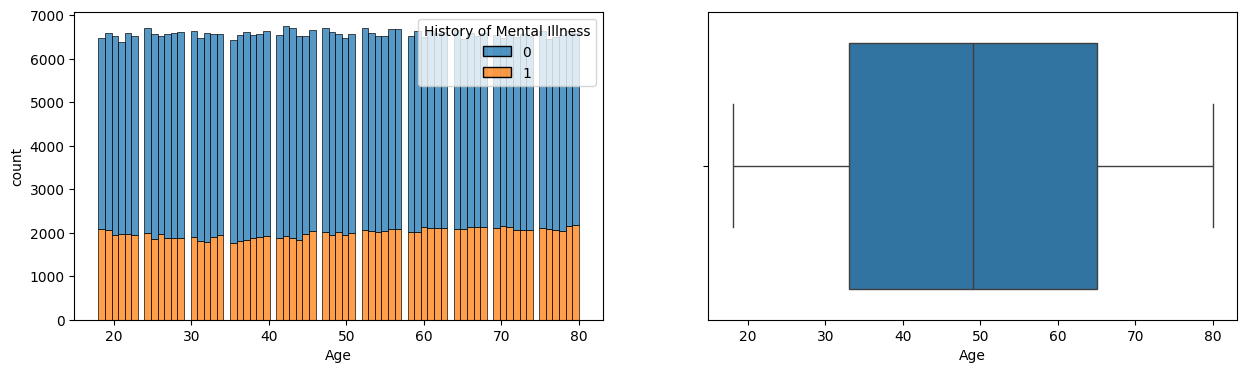

Number of Children
Skew : 0.43


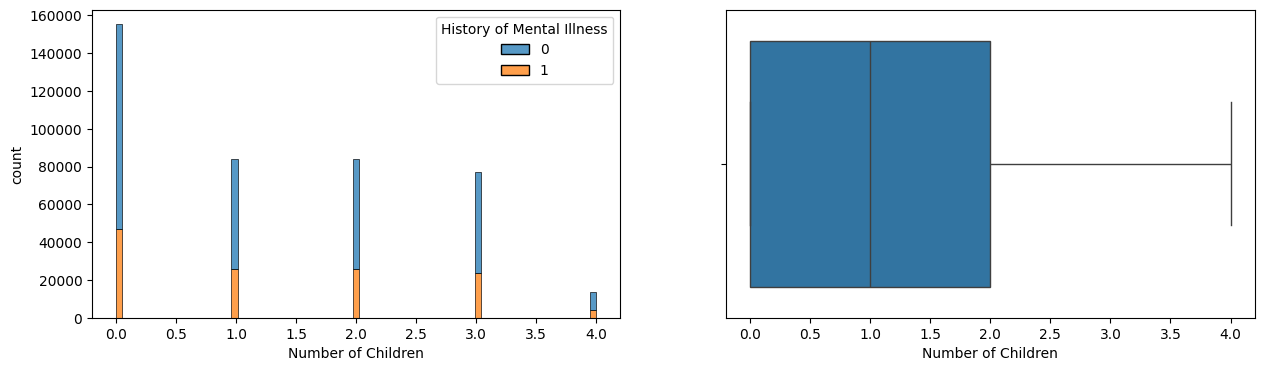

Income
Skew : 1.09


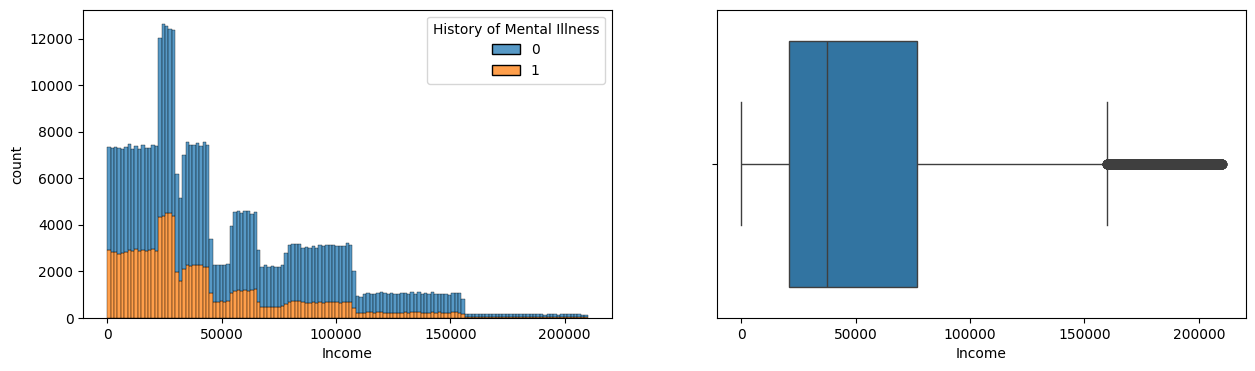

History of Mental Illness
Skew : 0.85


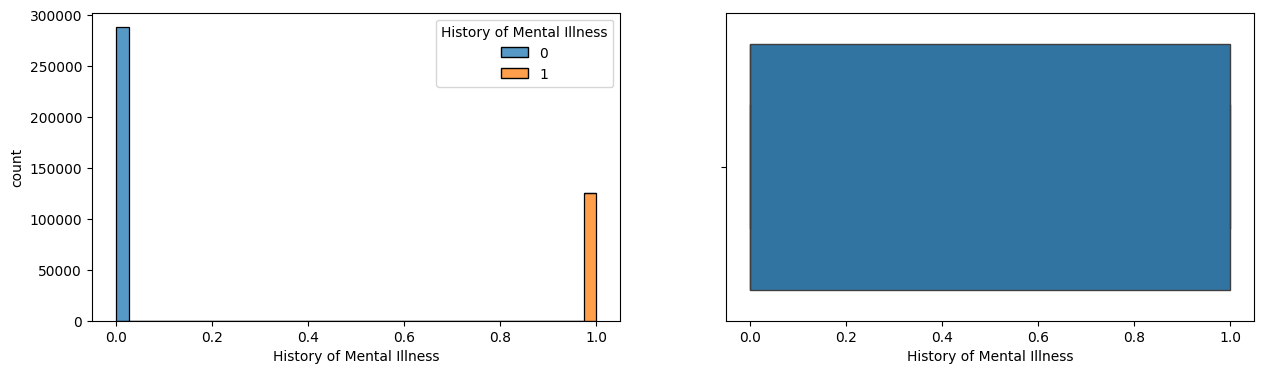

History of Substance Abuse
Skew : 0.81


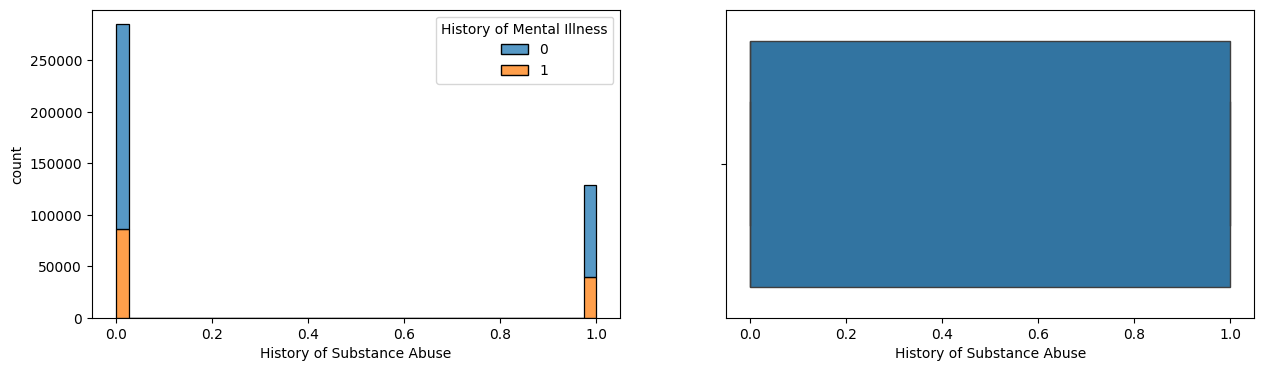

Family History of Depression
Skew : 1.04


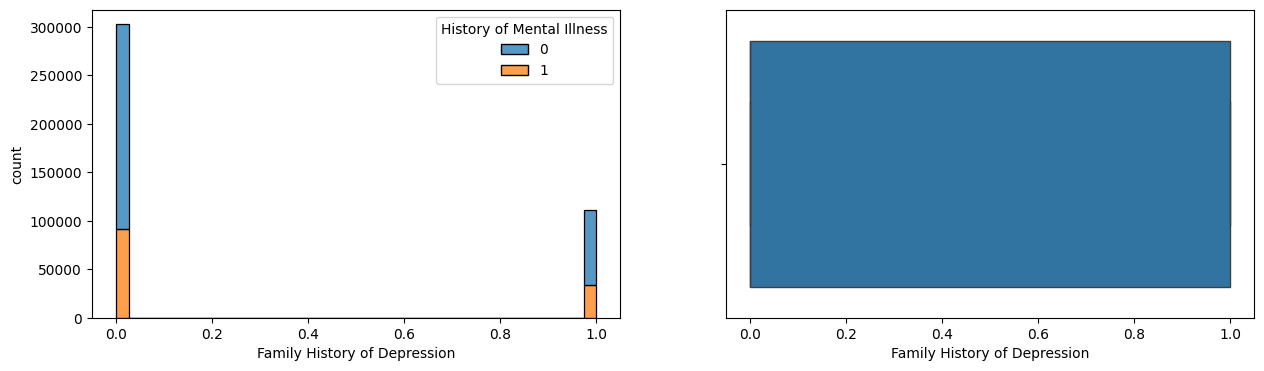

Chronic Medical Conditions
Skew : 0.73


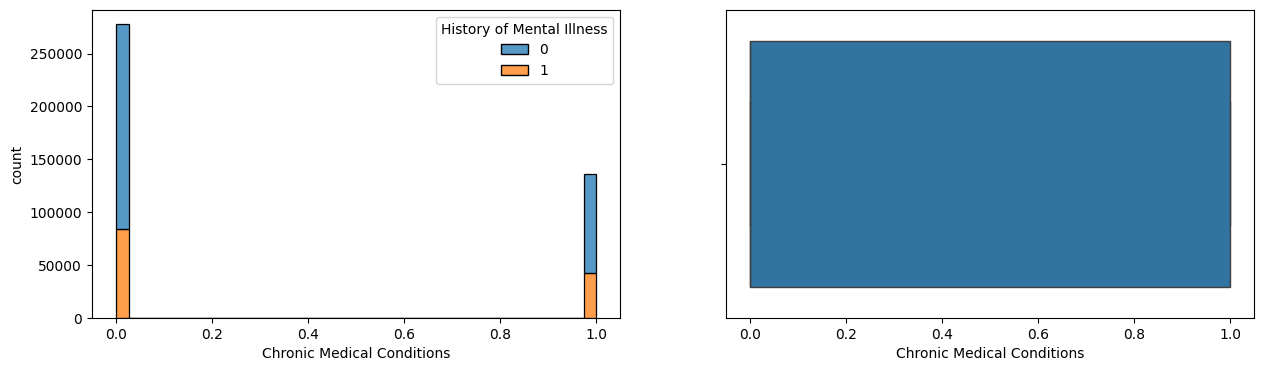

Has Children Flag
Skew : -0.52


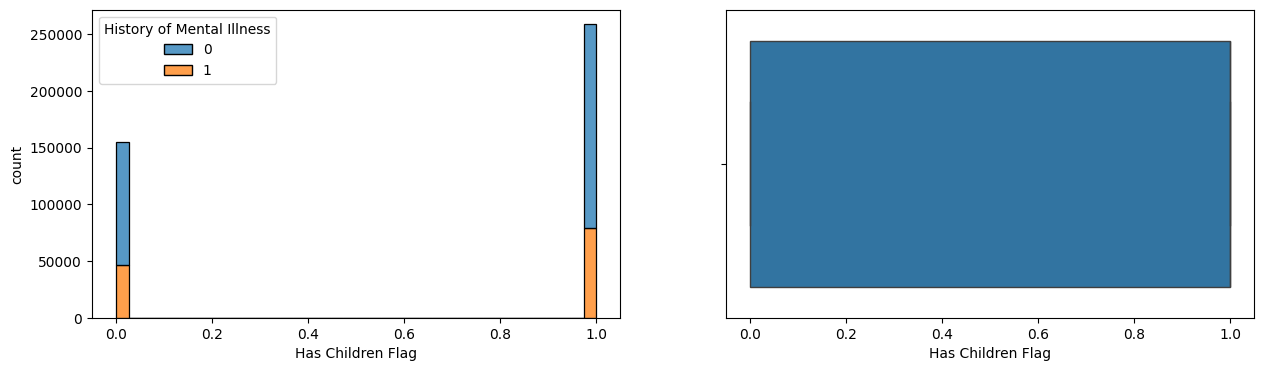

Income Square Root
Skew : 0.26


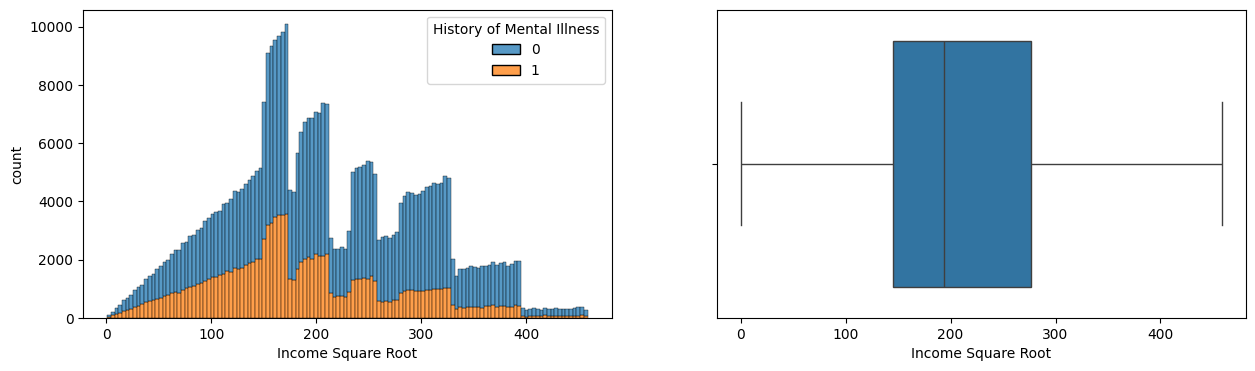

In [10]:
for col in num_cols:
    print(col)
    print('Skew :', round(data[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    # data[col].hist(grid=False)
    sns.histplot(bins='auto', x = col, hue="History of Mental Illness", data=data, multiple='stack');
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

### Review bar plots of categorical features

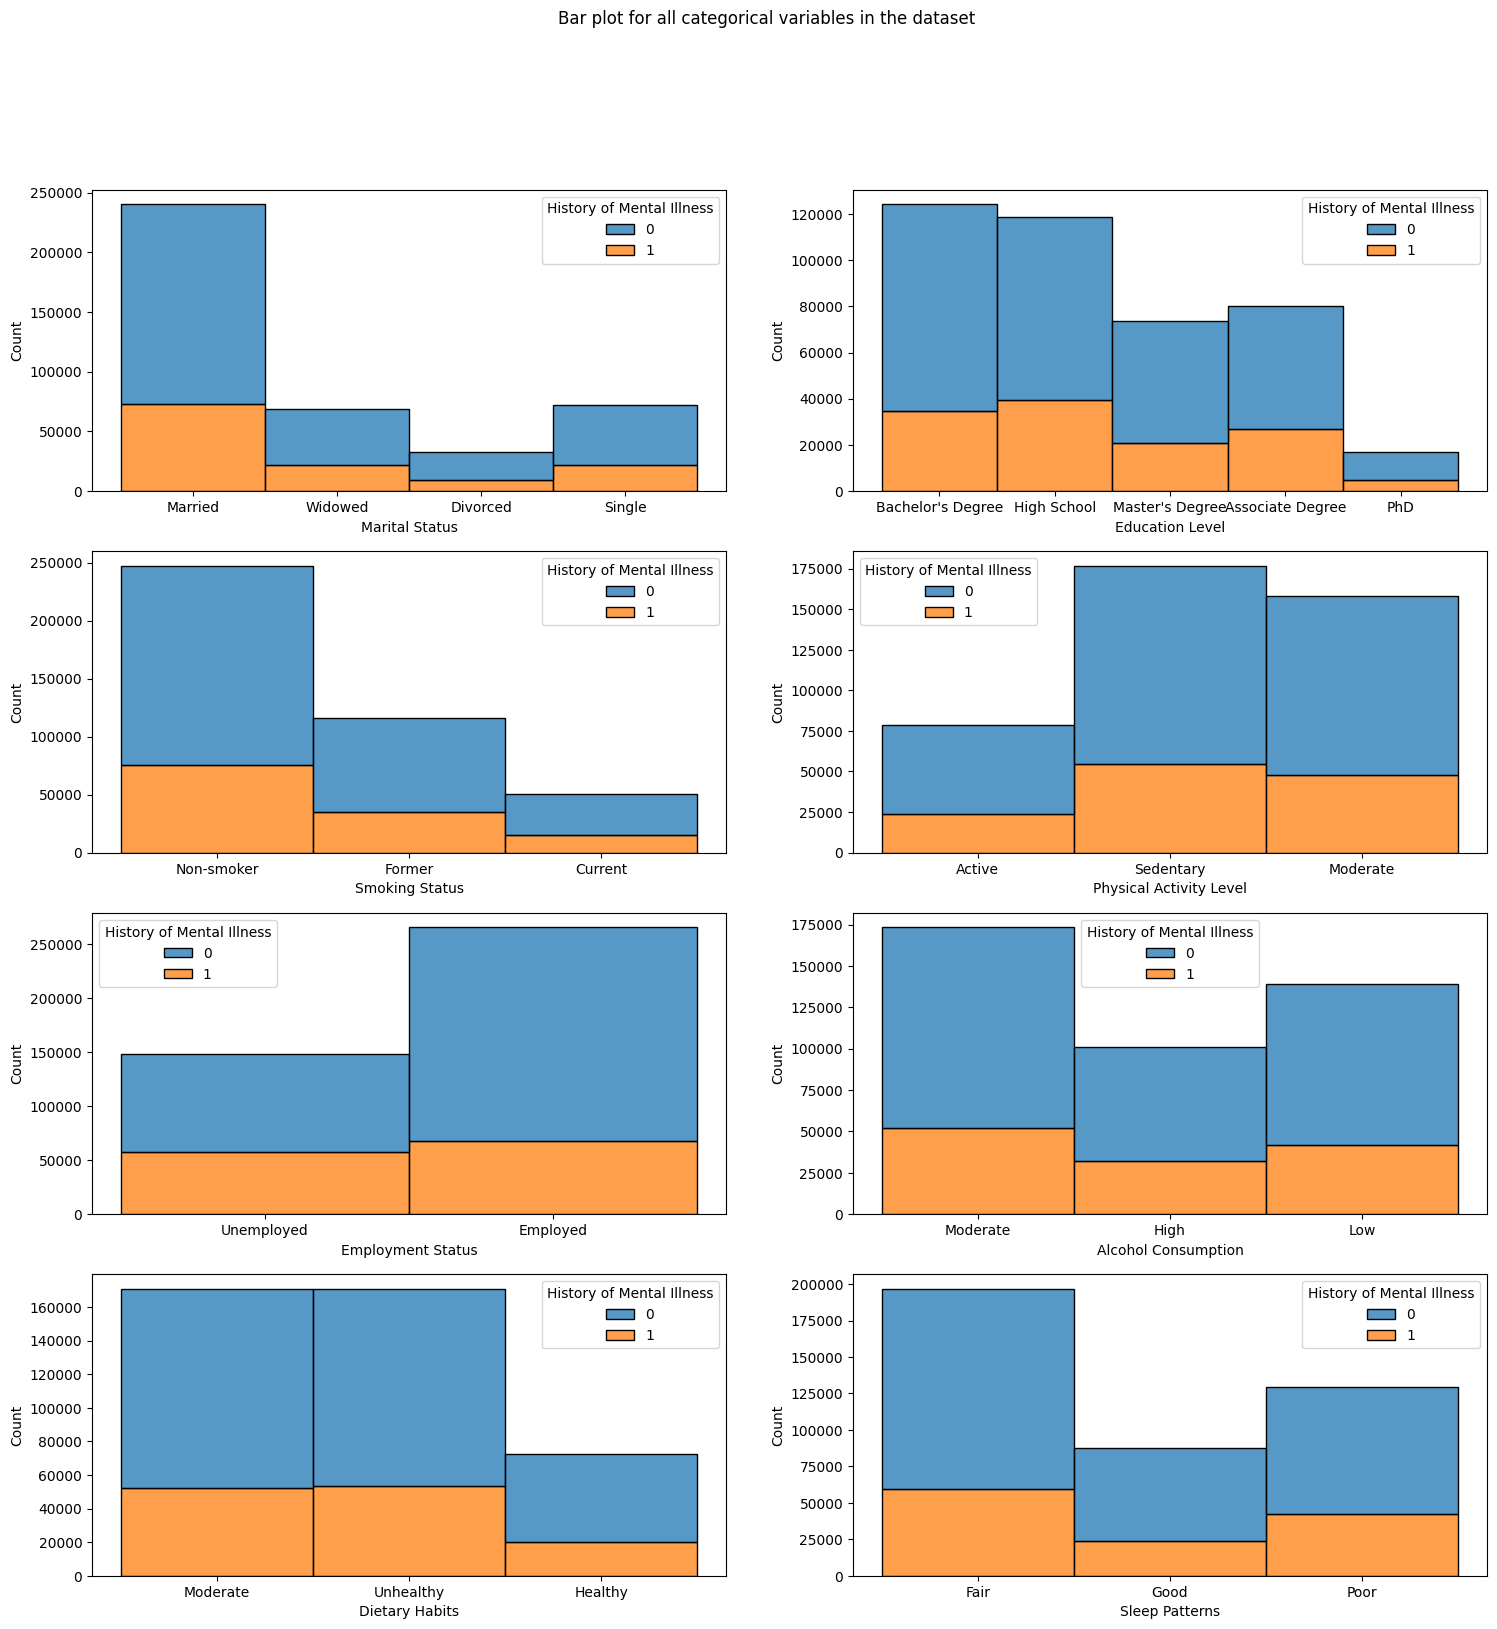

In [11]:
fig, axes = plt.subplots(4, 2, figsize = (18, 18))
fig.suptitle('Bar plot for all categorical variables in the dataset')
for i, col in enumerate(cat_cols):
    sns.histplot(ax = axes[i//2, i%2], binwidth=0.5, x = col, hue="History of Mental Illness", data=data, multiple='stack');

### Review correlation between numerical variables

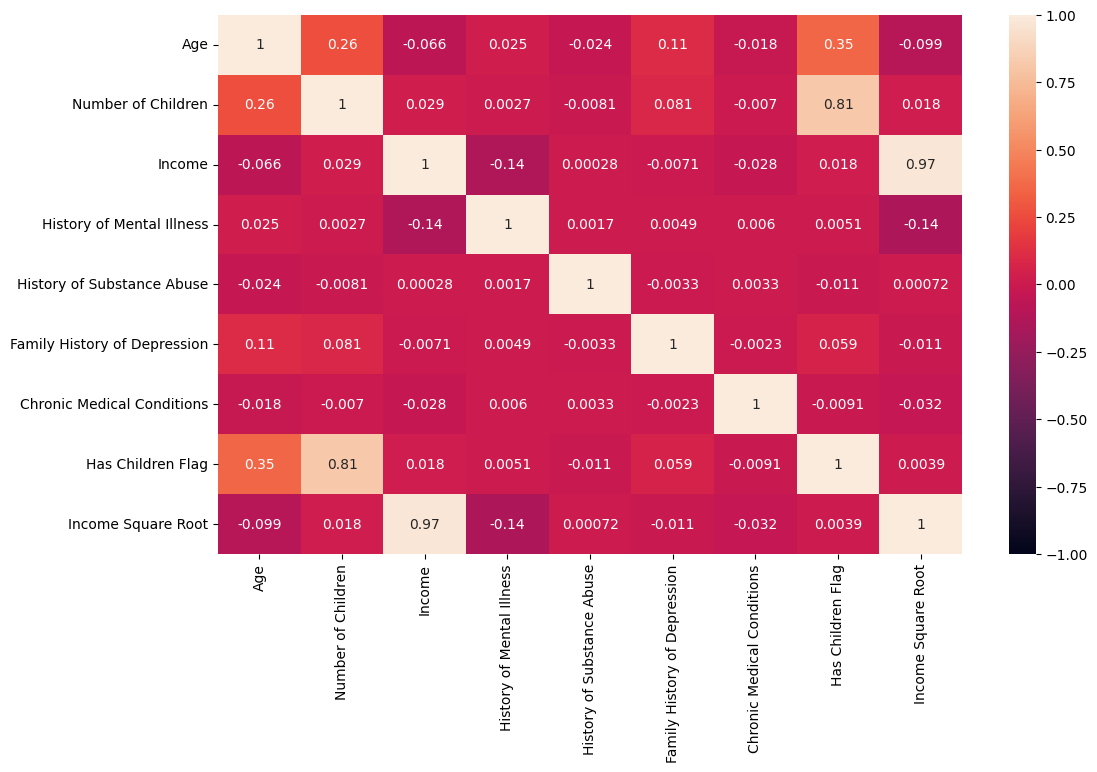

In [12]:
plt.figure(figsize=(12, 7))
sns.heatmap(data[num_cols].corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

### Review correlation to the target variable

In [13]:
# one hot encode categorical features
data_onehot = pd.get_dummies(data)

In [14]:
data_onehot[data_onehot.columns[1:]].corr()['History of Mental Illness'][:]

Number of Children                   0.002713
Income                              -0.136805
History of Mental Illness            1.000000
History of Substance Abuse           0.001733
Family History of Depression         0.004887
Chronic Medical Conditions           0.006038
Has Children Flag                    0.005147
Income Square Root                  -0.143059
Marital Status_Divorced             -0.006516
Marital Status_Married               0.001821
Marital Status_Single               -0.007040
Marital Status_Widowed               0.009500
Education Level_Associate Degree     0.031231
Education Level_Bachelor's Degree   -0.038089
Education Level_High School          0.036902
Education Level_Master's Degree     -0.024371
Education Level_PhD                 -0.011386
Smoking Status_Current              -0.004215
Smoking Status_Former               -0.002081
Smoking Status_Non-smoker            0.004714
Physical Activity Level_Active      -0.006869
Physical Activity Level_Moderate  

## Modelling Exploration
- Trialling Logistic Regression and XGBoost approaches

In [10]:
features = [
    'Age',
    'Marital Status',
    'Education Level',
    # 'Number of Children',
    'Smoking Status', 
    'Physical Activity Level',
    'Employment Status',
    'Alcohol Consumption',
    'Dietary Habits',
    'Sleep Patterns',
    'History of Substance Abuse',
    'Family History of Depression',
    'Chronic Medical Conditions',
    'Has Children Flag',
    'Income Square Root'
]
target = 'History of Mental Illness'

In [11]:
# categorical data inputs
for c in data.columns:
    if data[c].dtype == 'object':
        data[c] = data[c].astype('category')

Xcat = data[features]
ycat = data[target]

Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size=0.2)

In [12]:
# one-hot-encoded data inputs
X = pd.get_dummies(Xcat)

X_train, X_test, y_train, y_test = train_test_split(X, ycat, test_size=0.2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
# function to rapidly evaluate a candidate model
def quick_eval(mdl, X_t, y_t, nn=False):
    if nn:
        prob = mdl.predict(X_t)
        pred = [1 if e>0.5 else 0 for e in prob]
    else:
        pred = mdl.predict(X_t)
        prob = mdl.predict_proba(X_t)[:,1]
    print('Accuracy:', metrics.accuracy_score(y_t, pred))
    print('Precision:', metrics.precision_score(y_t, pred))
    print('Recall:', metrics.recall_score(y_t, pred))
    print('F1 Score:', metrics.f1_score(y_t, pred))

    fpr, tpr, thresholds = metrics.roc_curve(y_t, prob)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    if not nn:
        display = metrics.PrecisionRecallDisplay.from_estimator(
            mdl, X_t, y_t, name="LinearSVC", plot_chance_level=True
        )
        _ = display.ax_.set_title("2-class Precision-Recall curve")
        plt.show()
    

Accuracy: 0.6976339512289436
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


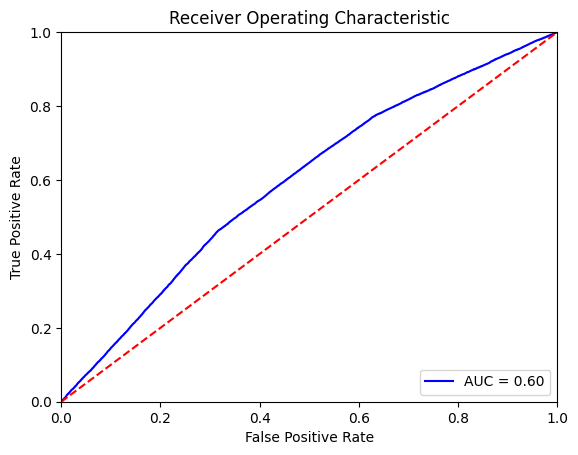

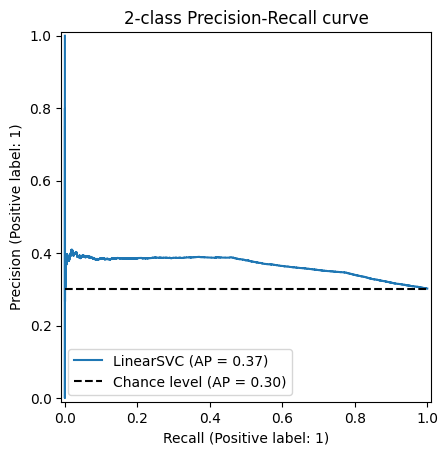

In [14]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

quick_eval(log_reg, X_test, y_test)

Accuracy: 0.6946371172390459
Precision: 0.3658119658119658
Recall: 0.008521482897304184
F1 Score: 0.016654992606428515


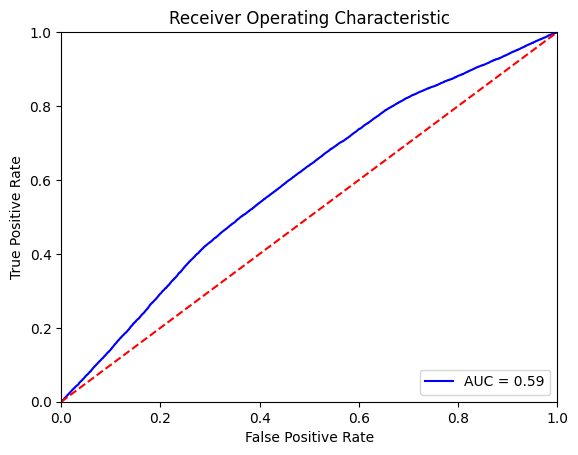

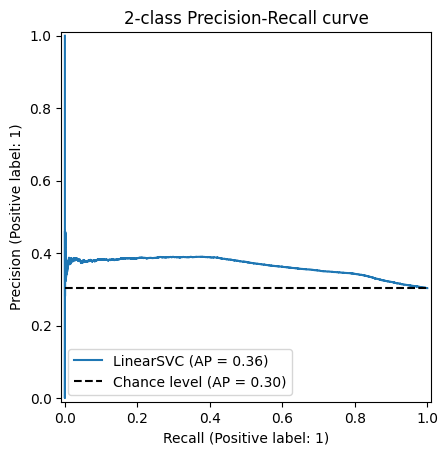

In [86]:
xgb = XGBClassifier(enable_categorical=True)
xgb.fit(Xcat_train, ycat_train)

quick_eval(xgb, Xcat_test, ycat_test)

Accuracy: 0.6447905841409479
Precision: 0.3447136563876652
Recall: 0.1865686469302603
F1 Score: 0.2421039061492845


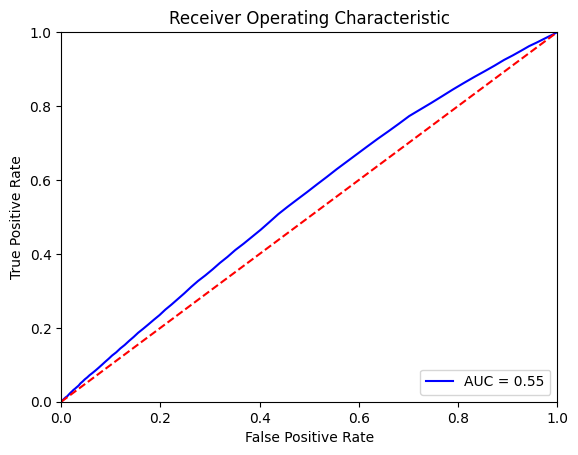

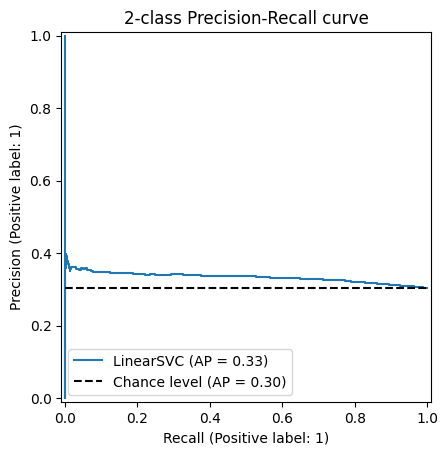

In [87]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

quick_eval(rnd_clf, X_test, y_test)

In [21]:
model = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(128, activation="relu"),
                  tf.keras.layers.Dense(1, activation="sigmoid")
 ])
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])
# Fit the model
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_test, y_test))

model.evaluate(X_test, y_test)

Epoch 1/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.6928 - loss: 0.6056 - val_accuracy: 0.6955 - val_loss: 0.6018
Epoch 2/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.6953 - loss: 0.6015 - val_accuracy: 0.6955 - val_loss: 0.6013
Epoch 3/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6965 - loss: 0.5996 - val_accuracy: 0.6955 - val_loss: 0.6014
Epoch 4/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6956 - loss: 0.6002 - val_accuracy: 0.6955 - val_loss: 0.6016
Epoch 5/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.6958 - loss: 0.6002 - val_accuracy: 0.6955 - val_loss: 0.6014
Epoch 6/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.6971 - loss: 0.5987 - val_accuracy: 0.6955 - val_loss: 0.6009
Epoch 7/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.6951 - loss: 0.6005 - val_accuracy: 0.6955 - val_loss: 0.6011
Epoch 8/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 

[0.6036379337310791, 0.6946975588798523]

2587/2587 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Accuracy: 0.6946975372791647
Precision: 0.3443396226415094
Recall: 0.002896940354775983
F1 Score: 0.005745543268663177


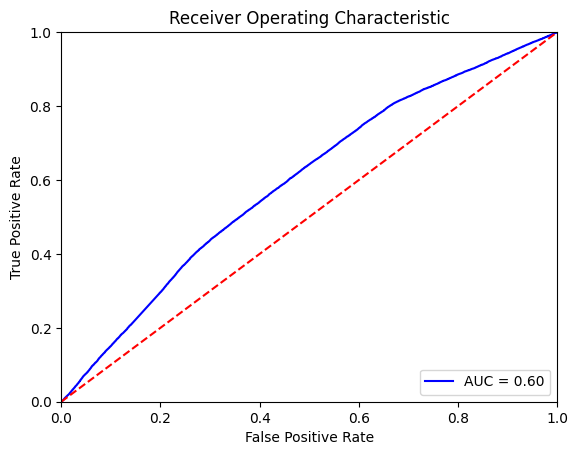

In [22]:
quick_eval(model, X_test, y_test, nn=True)

### Feature selection for Logistic Regression

### Training and evaluating a Logistic Regression

In [15]:
params = {
        'penalty': ['elasticnet', 'l1','l2'], 
        'C': [0.001,0.1,10,1000]
        }

model = LogisticRegression()

grid = GridSearchCV(
    estimator = model,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose = 3,
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 5/5] END .........C=0.001, penalty=elasticnet;, score=nan total time=   1.1s
[CV 3/5] END .........C=0.001, penalty=elasticnet;, score=nan total time=   1.3s
[CV 2/5] END .................C=0.001, penalty=l1;, score=nan total time=   1.3s
[CV 1/5] END .........C=0.001, penalty=elasticnet;, score=nan total time=   1.3s
[CV 4/5] END .........C=0.001, penalty=elasticnet;, score=nan total time=   1.3s
[CV 2/5] END .........C=0.001, penalty=elasticnet;, score=nan total time=   1.3s
[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   1.3s
[CV 3/5] END .................C=0.001, penalty=l1;, score=nan total time=   1.3s
[CV 4/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.1s
[CV 5/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.1s
[CV 1/5] END ...........C=0.1, penalty=elasticnet;, score=nan total time=   0.2s
[CV 2/5] END ...........C=0.1, penalty=elasticne

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 10, 1000],
                         'penalty': ['elasticnet', 'l1', 'l2']},
             scoring='roc_auc', verbose=3)

In [16]:
model = grid.best_estimator_

In [ ]:
prob = model.predict_proba(X_test)[:,1]
pred = y_pred = (prob >= 0.4).astype('int')

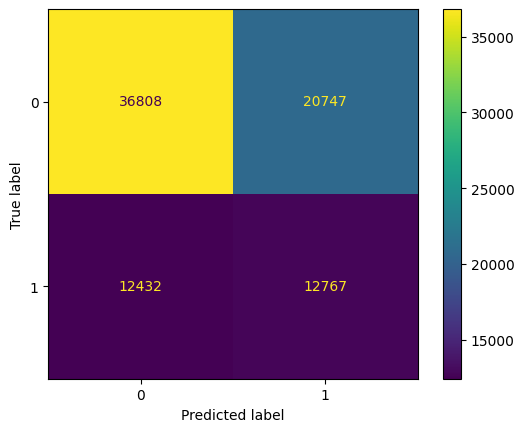

In [46]:
confusion_matrix = metrics.confusion_matrix(y_test,[1 if i>0.3 else 0 for i in prob[:,1]])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [27]:
print(f'Precision: {metrics.precision_score(y_test, pred)}')
print(f'Recall: {metrics.recall_score(y_test, pred)}')
print(f'Accuracy: {metrics.accuracy_score(y_test, pred)}')

Precision: 0.0
Recall: 0.0
Accuracy: 0.6954950818087343


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


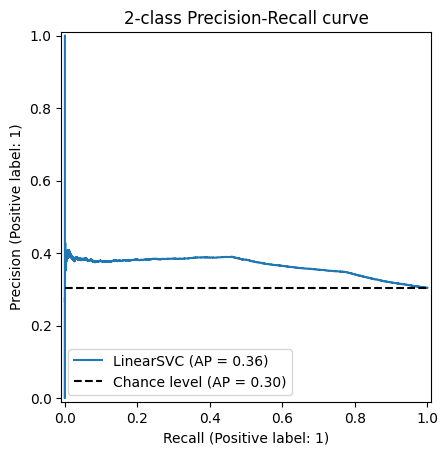

In [28]:
display = metrics.PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

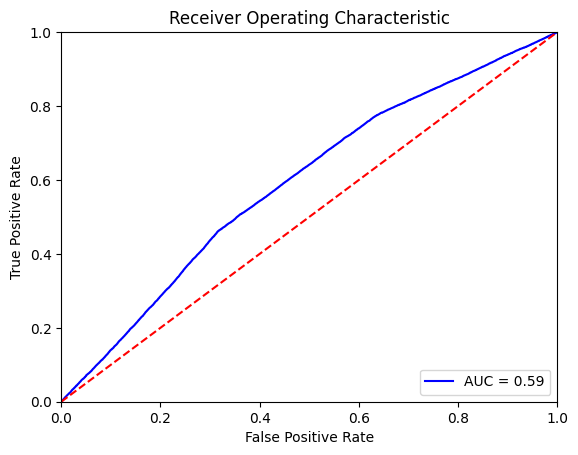

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [60]:
pd.DataFrame({'Feature':pd.get_dummies(data[features]).columns,
              'Coefficient':model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
22,Employment Status_Unemployed,0.097550
10,Education Level_Associate Degree,0.032149
12,Education Level_High School,0.019520
0,Age,0.014329
14,Education Level_PhD,0.010886
8,Marital Status_Single,0.007935
15,Smoking Status_Current,0.007016
31,Sleep Patterns_Poor,0.006772
3,Family History of Depression,0.006218
28,Dietary Habits_Unhealthy,0.005589
